In [1]:
!pip install pymoo

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 16.0 MB/s  0:00:00

   -------- ------------------------------- 2/9 [dill]
   -------- ------------------------------- 2/9 [dill]
   ------------- -------------------------- 3/9 [cma]
   ----------------- ---------------------- 4/9 [autograd]
   ---------------------- ----------------- 5/9 [about-time]
   ------------------------------- -------- 7/9 [alive-progress]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   ----------------------------------- ---- 8/9 [pymoo]
   

In [6]:
# NSGA-II con ZDT1 y DTLZ2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# CONFIGURACIÓN GENERAL
pop_size = 100
n_evals = 10000
n_gen = n_evals // pop_size
seeds = [42, 123, 456]

In [8]:
# FUNCIÓN AUXILIAR: Ejecuta NSGA-II y calcula métricas
def ejecutar_nsga2(nombre_problema):
    print(f"\n=== Ejecutando {nombre_problema.upper()} ===")
    problem = get_problem(nombre_problema)
    algorithm = NSGA2(pop_size=pop_size)
    results = []

    # --- Ejecutar múltiples veces con distintas semillas ---
    for seed in seeds:
        res = minimize(problem,
                       algorithm,
                       termination=('n_gen', n_gen),
                       seed=seed,
                       verbose=False)
        results.append(res)

    # --- Frente verdadero ---
    true_pf = problem.pareto_front()

    # --- Calcular métricas ---
    igd_values, hv_values = [], []
    ref_point = np.max(true_pf, axis=0) * 1.1

    for i, res in enumerate(results):
        F = res.F
        igd_val = IGD(true_pf)(F)
        hv_val = HV(ref_point=ref_point)(F)
        igd_values.append(igd_val)
        hv_values.append(hv_val)
        print(f"  Semilla {seeds[i]} -> IGD: {igd_val:.4f} | HV: {hv_val:.4f}")

    print(f"  IGD promedio: {np.mean(igd_values):.4f}")
    print(f"  HV promedio:  {np.mean(hv_values):.4f}")

    # --- Guardar resultados ---
    rep = results[0]
    np.savez(f"resultados_{nombre_problema}.npz",
             F=rep.F, X=rep.X,
             IGD=igd_values, HV=hv_values, seeds=seeds)

    # --- Visualización ---
    if rep.F.shape[1] == 2:
        plt.scatter(rep.F[:, 0], rep.F[:, 1], s=20, label="Frente obtenido")
        plt.scatter(true_pf[:, 0], true_pf[:, 1], s=10, label="Frente verdadero", alpha=0.6)
        plt.title(f"Frente de Pareto — {nombre_problema.upper()}")
        plt.xlabel("f1")
        plt.ylabel("f2")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    elif rep.F.shape[1] == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(rep.F[:, 0], rep.F[:, 1], rep.F[:, 2], s=15, label="Frente obtenido")
        ax.set_title(f"Frente de Pareto — {nombre_problema.upper()}")
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
        ax.set_zlabel("f3")
        plt.legend()
        plt.show()

    return igd_values, hv_values


=== Ejecutando ZDT1 ===
  Semilla 42 -> IGD: 0.0191 | HV: 0.8433
  Semilla 123 -> IGD: 0.0171 | HV: 0.8464
  Semilla 456 -> IGD: 0.0170 | HV: 0.8468
  IGD promedio: 0.0177
  HV promedio:  0.8455


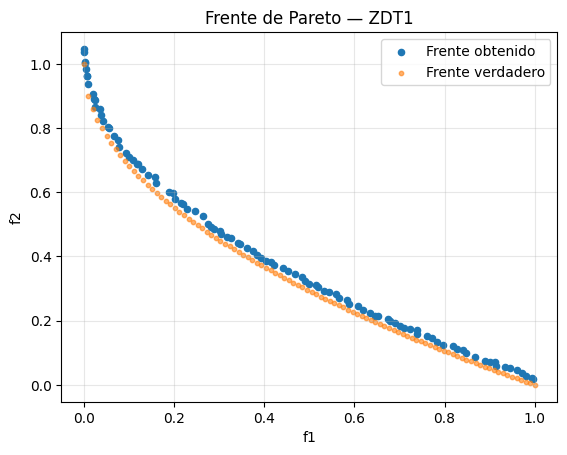


=== Ejecutando DTLZ2 ===
  Semilla 42 -> IGD: 0.0685 | HV: 0.7046
  Semilla 123 -> IGD: 0.0744 | HV: 0.7009
  Semilla 456 -> IGD: 0.0740 | HV: 0.7013
  IGD promedio: 0.0723
  HV promedio:  0.7023


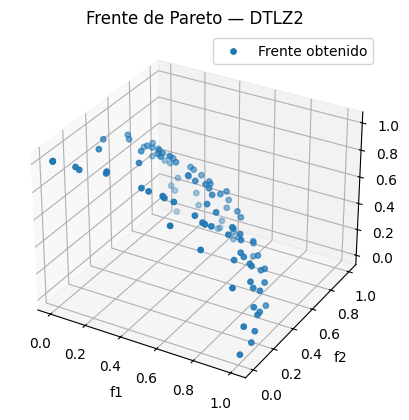


=== RESUMEN FINAL CON STD ===
Semilla 42 -> ZDT1: IGD=0.0191, HV=0.8433 | DTLZ2: IGD=0.0685, HV=0.7046
Semilla 123 -> ZDT1: IGD=0.0171, HV=0.8464 | DTLZ2: IGD=0.0744, HV=0.7009
Semilla 456 -> ZDT1: IGD=0.0170, HV=0.8468 | DTLZ2: IGD=0.0740, HV=0.7013

Promedios ZDT1 -> IGD=0.0177 ± 0.0010, HV=0.8455 ± 0.0016
Promedios DTLZ2 -> IGD=0.0723 ± 0.0027, HV=0.7023 ± 0.0017


In [9]:
# EJECUCIÓN
igd_zdt1, hv_zdt1 = ejecutar_nsga2("zdt1")
igd_dtlz2, hv_dtlz2 = ejecutar_nsga2("dtlz2")

# RESUMEN FINAL con promedio y std
print("\n=== RESUMEN FINAL CON STD ===")
for i, seed in enumerate(seeds):
    print(f"Semilla {seed} -> ZDT1: IGD={igd_zdt1[i]:.4f}, HV={hv_zdt1[i]:.4f} | "
          f"DTLZ2: IGD={igd_dtlz2[i]:.4f}, HV={hv_dtlz2[i]:.4f}")

# Promedios
print(f"\nPromedios ZDT1 -> IGD={np.mean(igd_zdt1):.4f} ± {np.std(igd_zdt1):.4f}, "
      f"HV={np.mean(hv_zdt1):.4f} ± {np.std(hv_zdt1):.4f}")
print(f"Promedios DTLZ2 -> IGD={np.mean(igd_dtlz2):.4f} ± {np.std(igd_dtlz2):.4f}, "
      f"HV={np.mean(hv_dtlz2):.4f} ± {np.std(hv_dtlz2):.4f}")
